# Setup 

### used the same code given in this lab

In [55]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Download the Data

In [56]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [57]:
fetch_housing_data()

C:\Users\saira\AppData\Local\Temp\ipykernel_9388\1387014147.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [58]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## loading the dataset

In [59]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Create a Test Set

In [60]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [61]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [62]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [63]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [64]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [65]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [66]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [67]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [68]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<Axes: >

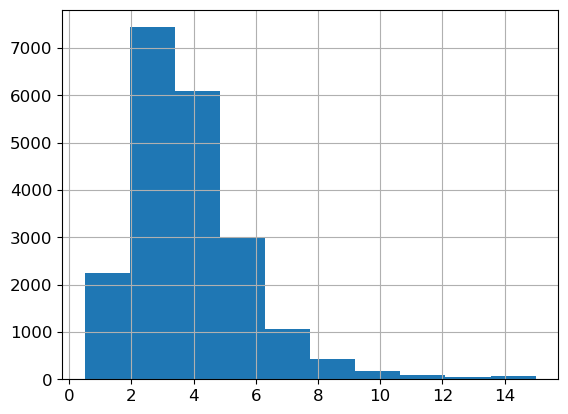

In [69]:
housing["median_income"].hist()

In [70]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [71]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

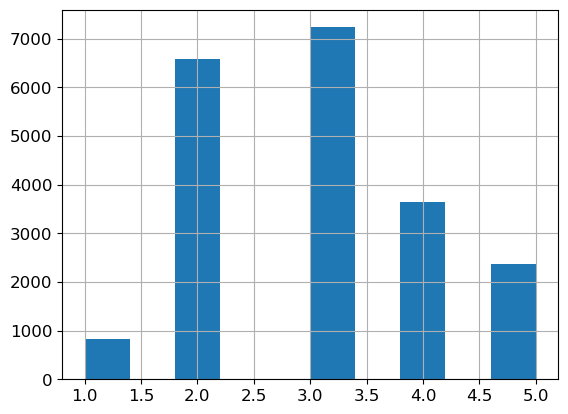

In [72]:
housing["income_cat"].hist()

In [73]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [74]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [75]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [76]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [77]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Strat train set into housing

In [78]:
housing = strat_train_set.copy()

# Prepare the Data for Machine Learning Algorithms

In [79]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [80]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [81]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [82]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [83]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [84]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [85]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute:

In [86]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:

In [87]:
X = imputer.transform(housing_num)

In [88]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [89]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [90]:
imputer.strategy

'median'

In [91]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [92]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [93]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [94]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Custom Transformers

Let's create a custom transformer to add extra attributes:

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:

In [96]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [98]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [99]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [100]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Select and Train a Model

## Training and Evaluating on the Training Set

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# housing_prepared and housing_labels are trained sets

### Linear Regression

In [103]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print(lin_rmse)
lin_mae

68627.87390018745


49438.66860915803

### Decision Tree Regressor

In [104]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_mae = mean_absolute_error(housing_labels, housing_predictions)

### Random Forest Regressor

In [105]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
forest_mae = mean_absolute_error(housing_labels, housing_predictions)

### Support Vector Regressor

In [106]:
# from  grid_search.best_params_ we get c=30000.0 and kernel="linear"
svm_reg = SVR(kernel="linear", C=300000.0)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
svm_mae = mean_absolute_error(housing_labels, housing_predictions)

# Hyperparameter tuning

In [125]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from scipy.stats import randint, uniform
import numpy as np

Linear Regression RMSE: 69065.59069601327

Decision Tree Grid Search Results:
RMSE: 62739.780496000894, Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
RMSE: 62056.24290857084, Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
RMSE: 61398.35911620111, Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
RMSE: 60497.56466451291, Params: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
RMSE: 60497.56466451291, Params: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
RMSE: 60217.026269815775, Params: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
RMSE: 60069.74163012489, Params: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
RMSE: 60069.74163012489, Params: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
RMSE: 60069.74163012489, Params: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}
RMSE: 70437.13337621602, Para


## 1. Linear Regression (No hyperparameter tuning needed for Linear Regression)


In [ ]:

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


# Evaluate Linear Regression directly
lin_reg_rmse = np.sqrt(-cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=5))
print("Linear Regression RMSE:", lin_reg_rmse.mean())



## 2. Decision Tree Regressor



### Grid Search for Decision Tree Regressor


In [ ]:

param_grid_tree = [
    {'max_depth': [10, 20, 30, None], 
     'min_samples_split': [2, 10, 20], 
     'min_samples_leaf': [1, 5, 10]},
]

tree_reg = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(tree_reg, param_grid_tree, cv=5,
                                scoring='neg_mean_squared_error', return_train_score=True)
grid_search_tree.fit(housing_prepared, housing_labels)

print("\nDecision Tree Grid Search Results:")
cvres_tree = grid_search_tree.cv_results_
for mean_score, params in zip(cvres_tree["mean_test_score"], cvres_tree["params"]):
    print(f"RMSE: {np.sqrt(-mean_score)}, Params: {params}")



### Randomized Search for Decision Tree Regressor


In [ ]:

param_distribs_tree = {
    'max_depth': randint(low=1, high=50),
    'min_samples_split': randint(low=2, high=20),
    'min_samples_leaf': randint(low=1, high=20),
}

rnd_search_tree = RandomizedSearchCV(tree_reg, param_distributions=param_distribs_tree,
                                     n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_tree.fit(housing_prepared, housing_labels)

print("\nDecision Tree Random Search Results:")
cvres_rnd_tree = rnd_search_tree.cv_results_
for mean_score, params in zip(cvres_rnd_tree["mean_test_score"], cvres_rnd_tree["params"]):
    print(f"RMSE: {np.sqrt(-mean_score)}, Params: {params}")



## 3. Random Forest Regressor



### Grid Search for Random Forest Regressor


In [ ]:

param_grid_forest = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search_forest = GridSearchCV(forest_reg, param_grid_forest, cv=5,
                                  scoring='neg_mean_squared_error', return_train_score=True)
grid_search_forest.fit(housing_prepared, housing_labels)

print("\nRandom Forest Grid Search Results:")
cvres_forest = grid_search_forest.cv_results_
for mean_score, params in zip(cvres_forest["mean_test_score"], cvres_forest["params"]):
    print(f"RMSE: {np.sqrt(-mean_score)}, Params: {params}")



### Randomized Search for Random Forest Regressor


In [ ]:

param_distribs_forest = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

rnd_search_forest = RandomizedSearchCV(forest_reg, param_distributions=param_distribs_forest,
                                       n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_forest.fit(housing_prepared, housing_labels)

print("\nRandom Forest Random Search Results:")
cvres_rnd_forest = rnd_search_forest.cv_results_
for mean_score, params in zip(cvres_rnd_forest["mean_test_score"], cvres_rnd_forest["params"]):
    print(f"RMSE: {np.sqrt(-mean_score)}, Params: {params}")



## 4. Support Vector Machine Regressor (SVR)



### Grid Search for SVR


In [ ]:

param_grid_svr = [
    {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svr_reg = SVR()
grid_search_svr = GridSearchCV(svr_reg, param_grid_svr, cv=5,
                               scoring='neg_mean_squared_error', return_train_score=True)
grid_search_svr.fit(housing_prepared, housing_labels)

print("\nSVR Grid Search Results:")
cvres_svr = grid_search_svr.cv_results_
for mean_score, params in zip(cvres_svr["mean_test_score"], cvres_svr["params"]):
    print(f"RMSE: {np.sqrt(-mean_score)}, Params: {params}")



### Randomized Search for SVR


In [ ]:

param_distribs_svr = {
    'C': uniform(0.1, 100),
    'epsilon': uniform(0.01, 1),
    'kernel': ['linear', 'rbf'],
}

rnd_search_svr = RandomizedSearchCV(svr_reg, param_distributions=param_distribs_svr,
                                    n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_svr.fit(housing_prepared, housing_labels)

print("\nSVR Random Search Results:")
cvres_rnd_svr = rnd_search_svr.cv_results_
for mean_score, params in zip(cvres_rnd_svr["mean_test_score"], cvres_rnd_svr["params"]):
    print(f"RMSE: {np.sqrt(-mean_score)}, Params: {params}")


# Results and analysis

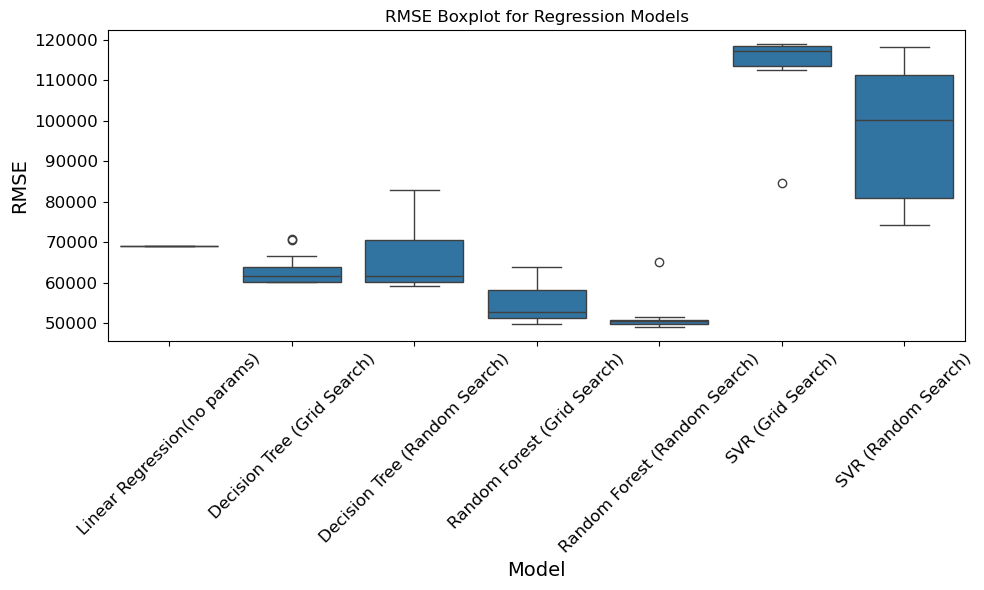

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# RMSE results for each model
rmse_values = {
    'Linear Regression(no params)': [69065.59],
    'Decision Tree (Grid Search)': [
        62739.78, 62056.24, 61398.36, 60497.56, 60217.03, 60069.74, 70437.13,
        66166.72, 63715.25, 62435.36, 60808.02, 60165.48, 70911.54, 66569.94, 
        63869.70, 60165.19, 60165.19, 60165.19
    ],
    'Decision Tree (Random Search)': [
        59247.69, 61541.04, 60999.44, 65583.67, 59454.41, 82843.87, 75687.40
    ],
    'Random Forest (Grid Search)': [
        63895.16, 54916.32, 52885.87, 60075.37, 52495.01, 50187.24, 58064.74, 
        51519.32, 49969.80, 58895.82, 52459.80, 49898.99
    ],
    'Random Forest (Random Search)': [
        49117.55, 51450.63, 50692.54, 50783.61, 49162.90, 50655.80, 50513.86, 
        49521.17, 50302.90, 65167.02
    ],
    'SVR (Grid Search)': [
        118258.82, 118905.81, 112571.06, 118638.40, 84649.62, 116126.66
    ],
    'SVR (Random Search)': [
        74380.38, 101305.47, 114618.18, 74905.29, 118319.86, 98908.36
    ]
}

# Prepare data for plotting
data = []
for model, rmse_list in rmse_values.items():
    for rmse in rmse_list:
        data.append([model, rmse])

df = pd.DataFrame(data, columns=['Model', 'RMSE'])

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='RMSE', data=df)
plt.xticks(rotation=45)
plt.title('RMSE Boxplot for Regression Models')
plt.tight_layout()

# Show plot
plt.show()


### Evaluating the test set with best model

In [136]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get the best model from Hyperparameter tuning
final_model = rnd_search.best_estimator_

# Prepare the test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Apply the same transformations to the test set as the training set
X_test_prepared = full_pipeline.transform(X_test)

# Make predictions on the test set using the best model
final_predictions = final_model.predict(X_test_prepared)

# Calculate the MSE and RMSE for the test set
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# Output the model name and the RMSE value
print("Best Model:", final_model.__class__.__name__)
print("Final RMSE on the test set:", final_rmse)



Best Model: RandomForestRegressor
Final RMSE on the test set: 46981.841079394515
